
# Deadline Prediction (LSTM + DNN) — Using Only PM Inputs


In [18]:

import os, math, warnings, json
from pathlib import Path
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import root_mean_squared_error

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, utils

warnings.filterwarnings("ignore")

PROJECTS = {
    "Aurora": {
        "issues":  r"PM_Kaggle_dataset\AgileScrumSprintVelocityDataSet\Agile Scrum Dataset\Finalized Datasets for Aurora Project\Aurora Issues 554.csv",
        "summary": r"PM_Kaggle_dataset\AgileScrumSprintVelocityDataSet\Agile Scrum Dataset\Finalized Datasets for Aurora Project\Aurora Issues summery 568.csv",
        "sprints": r"PM_Kaggle_dataset\AgileScrumSprintVelocityDataSet\Agile Scrum Dataset\Finalized Datasets for Aurora Project\Aurora Sprints 41.csv",
    },
    "Meso": {
        "issues":  r"PM_Kaggle_dataset\AgileScrumSprintVelocityDataSet\Agile Scrum Dataset\Finalized Datasets for Meso Project\Mesos Stories 176.csv",
        "summary": r"PM_Kaggle_dataset\AgileScrumSprintVelocityDataSet\Agile Scrum Dataset\Finalized Datasets for Meso Project\MESO Issue Summary 370.csv",
        "sprints": r"PM_Kaggle_dataset\AgileScrumSprintVelocityDataSet\Agile Scrum Dataset\Finalized Datasets for Meso Project\MESO Sprint 96.csv",
    },
    "SpringXD": {
        "issues":  r"PM_Kaggle_dataset\AgileScrumSprintVelocityDataSet\Agile Scrum Dataset\Finalized Datasets for Spring XD Project by Randula\Spring XD Issues 1992.csv",
        "summary": r"PM_Kaggle_dataset\AgileScrumSprintVelocityDataSet\Agile Scrum Dataset\Finalized Datasets for Spring XD Project by Randula\Spring XD Issues Summary 2861.csv",
        "sprints": r"PM_Kaggle_dataset\AgileScrumSprintVelocityDataSet\Agile Scrum Dataset\Finalized Datasets for Spring XD Project by Randula\Spring XD Sprints 67.csv",
    },
    "UserGrid": {
        "issues":  r"PM_Kaggle_dataset\AgileScrumSprintVelocityDataSet\Agile Scrum Dataset\Finalized Datasets for UserGrid\Usergrid Issues 824.csv",
        "summary": r"PM_Kaggle_dataset\AgileScrumSprintVelocityDataSet\Agile Scrum Dataset\Finalized Datasets for UserGrid\Usergrid Issues Summary 929.csv",
        "sprints": r"PM_Kaggle_dataset\AgileScrumSprintVelocityDataSet\Agile Scrum Dataset\Finalized Datasets for UserGrid\Usergrid Sprints 36.csv",
    },
}

PRED_FEATURES = ["issuetype","priorityid","storyPoint","project","summary"]


In [19]:

def _lower_cols(df):
    df = df.copy()
    df.columns = [c.strip().replace(" ", "_").lower() for c in df.columns]
    return df

def _to_dt(s):
    try: return pd.to_datetime(s, errors="coerce")
    except: return pd.NaT

def load_and_build_dataset(projects):
    frames = []
    for pname, mp in projects.items():
        try:
            iss = _lower_cols(pd.read_csv(mp["issues"], on_bad_lines="skip", engine="python"))
        except Exception as e:
            print(f"Issues load failed for {pname}: {e}")
            continue

        if "priority" in iss.columns and "priorityid" not in iss.columns:
            iss.rename(columns={"priority":"priorityid"}, inplace=True)
        if "storypoints" in iss.columns and "storypoint" not in iss.columns:
            iss.rename(columns={"storypoints":"storypoint"}, inplace=True)

        try:
            summ = _lower_cols(pd.read_csv(mp["summary"], on_bad_lines="skip", engine="python"))
        except Exception:
            summ = pd.DataFrame()
        try:
            spr = _lower_cols(pd.read_csv(mp["sprints"], on_bad_lines="skip", engine="python"))
        except Exception:
            spr = pd.DataFrame()

        for c in ["created","createddate","resolutiondate","resolved"]:
            if c in iss.columns: iss[c] = _to_dt(iss[c])
        for c in ["sprintstartdate","sprintenddate"]:
            if c in spr.columns: spr[c] = _to_dt(spr[c])

        def target_from_issue_dates(row):
            cr = row.get("created", row.get("createddate", pd.NaT))
            rs = row.get("resolved", row.get("resolutiondate", pd.NaT))
            if pd.notna(cr) and pd.notna(rs):
                d = (rs - cr).days
                return d if d and d > 0 else np.nan
            return np.nan

        iss["target_days"] = iss.apply(target_from_issue_dates, axis=1)

        if iss["target_days"].isna().all() and not summ.empty and not spr.empty:
            if ("issuekey" in summ.columns) and ("sprintid" in summ.columns) and \
               ("sprintid" in spr.columns) and ("sprintstartdate" in spr.columns) and ("sprintenddate" in spr.columns):
                sj = summ[["issuekey","sprintid"]].merge(
                    spr[["sprintid","sprintstartdate","sprintenddate"]], on="sprintid", how="left"
                )
                sj["sprint_len"] = (sj["sprintenddate"] - sj["sprintstartdate"]).dt.days
                if "key" in iss.columns:
                    iss = iss.merge(sj[["issuekey","sprint_len"]], left_on="key", right_on="issuekey", how="left")
                    iss["target_days"] = iss["target_days"].fillna(iss["sprint_len"])
                    iss.drop(columns=[c for c in ["issuekey","sprint_len"] if c in iss.columns], inplace=True)

        iss["project"] = pname
        if "summary" not in iss.columns: iss["summary"] = ""

        keep = ["issuetype","priorityid","storypoint","project","summary","target_days"]
        for k in keep:
            if k not in iss.columns:
                iss[k] = np.nan if k=="target_days" else ("Unknown" if k in ["issuetype","project","summary"] else 0)

        frames.append(iss[keep])

    if not frames:
        raise RuntimeError("No data loaded.")
    data = pd.concat(frames, ignore_index=True)

    data["priorityid"] = pd.to_numeric(data["priorityid"], errors="coerce").fillna(3).astype(int)
    data["storypoint"] = pd.to_numeric(data["storypoint"], errors="coerce").fillna(1).astype(float)
    data["issuetype"] = data["issuetype"].fillna("Unknown").astype(str)
    data["project"] = data["project"].fillna("Unknown").astype(str)
    data["summary"] = data["summary"].fillna("").astype(str)

    mask = data["target_days"].notna() & (data["target_days"] > 0)
    data = data[mask].copy()
    data["target_days"] = data["target_days"].astype(float)
    return data

df = load_and_build_dataset(PROJECTS)
print("Dataset:", df.shape)
df.head(3)


Dataset: (6128, 6)


,issuetype,priorityid,storypoint,project,summary,target_days
0,Story,3,1.0,Aurora,Parallelize updates to speed up deploys,5.0
1,Story,3,1.0,Aurora,Parallelize updates to speed up deploys,5.0
2,Story,3,1.0,Aurora,Parallelize updates to speed up deploys,5.0


In [20]:

RANDOM_STATE = 42
features = ["issuetype","priorityid","storypoint","project","summary"]
target = "target_days"

X = df[features].copy()
y = df[target].copy()

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=RANDOM_STATE)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=RANDOM_STATE)
print("Train:", X_train.shape, " Val:", X_val.shape, " Test:", X_test.shape)


Train: (4289, 5)  Val: (919, 5)  Test: (920, 5)


In [21]:

MAX_TOKENS = 20000
MAX_LEN = 60

text_vec = layers.TextVectorization(
    max_tokens=MAX_TOKENS,
    standardize="lower_and_strip_punctuation",
    output_mode="int",
    output_sequence_length=MAX_LEN,
)
text_vec.adapt(X_train["summary"].values)

issuetype_lookup = layers.StringLookup()
issuetype_lookup.adapt(X_train["issuetype"].values)
project_lookup = layers.StringLookup()
project_lookup.adapt(X_train["project"].values)

norm_priority = layers.Normalization()
norm_priority.adapt(X_train["priorityid"].astype(float).values.reshape(-1,1))

norm_story = layers.Normalization()
norm_story.adapt(X_train["storypoint"].astype(float).values.reshape(-1,1))

inp_summary = layers.Input(shape=(), dtype=tf.string, name="summary")
inp_issue   = layers.Input(shape=(), dtype=tf.string, name="issuetype")
inp_proj    = layers.Input(shape=(), dtype=tf.string, name="project")
inp_prio    = layers.Input(shape=(1,), dtype=tf.float32, name="priorityid")
inp_sp      = layers.Input(shape=(1,), dtype=tf.float32, name="storypoint")

x_text = text_vec(inp_summary)
x_text = layers.Embedding(input_dim=MAX_TOKENS, output_dim=64, mask_zero=True)(x_text)
x_text = layers.Bidirectional(layers.LSTM(64, return_sequences=False))(x_text)
x_text = layers.Dropout(0.3)(x_text)

x_issue = issuetype_lookup(inp_issue)
x_issue = layers.Embedding(input_dim=issuetype_lookup.vocabulary_size(), output_dim=8)(x_issue)
x_issue = layers.Flatten()(x_issue)

x_proj = project_lookup(inp_proj)
x_proj = layers.Embedding(input_dim=project_lookup.vocabulary_size(), output_dim=8)(x_proj)
x_proj = layers.Flatten()(x_proj)

x_prio = norm_priority(inp_prio)
x_sp   = norm_story(inp_sp)

x = layers.Concatenate()([x_text, x_issue, x_proj, x_prio, x_sp])
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(64, activation="relu")(x)
out = layers.Dense(1, activation="linear")(x)

model_lstm = models.Model(
    inputs=[inp_summary, inp_issue, inp_proj, inp_prio, inp_sp],
    outputs=out, name="deadline_lstm"
)
model_lstm.compile(optimizer="adam", loss="mae", metrics=["mse"])

def df_to_inputs(df_part):
    return {
        "summary": df_part["summary"].values,
        "issuetype": df_part["issuetype"].values,
        "project": df_part["project"].values,
        "priorityid": df_part["priorityid"].astype(float).values.reshape(-1,1),
        "storypoint": df_part["storypoint"].astype(float).values.reshape(-1,1),
    }

es = callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor="val_loss")
hist_lstm = model_lstm.fit(
    df_to_inputs(X_train), y_train.values,
    validation_data=(df_to_inputs(X_val), y_val.values),
    epochs=30, batch_size=64, callbacks=[es], verbose=1
)

def eval_reg(y_true, y_pred, name):
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"[{name}] MAE={mae:.2f} | MAPE={mape:.2%} | RMSE={rmse:.2f} | R²={r2:.3f}")
    return mae, mape, rmse, r2

y_hat_val = model_lstm.predict(df_to_inputs(X_val)).ravel()
y_hat_test = model_lstm.predict(df_to_inputs(X_test)).ravel()
eval_reg(y_val, y_hat_val, "LSTM VAL")
eval_reg(y_test, y_hat_test, "LSTM TEST")


Epoch 1/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - loss: 7.1994 - mse: 79.9324 - val_loss: 3.5046 - val_mse: 22.2797
Epoch 2/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 3.4625 - mse: 21.4473 - val_loss: 3.0389 - val_mse: 18.0518
Epoch 3/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 3.0773 - mse: 17.4909 - val_loss: 3.0176 - val_mse: 17.5003
Epoch 4/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 2.7989 - mse: 14.9999 - val_loss: 2.8457 - val_mse: 16.6331
Epoch 5/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 2.6037 - mse: 13.4261 - val_loss: 3.1374 - val_mse: 18.0363
Epoch 6/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 2.4960 - mse: 12.5978 - val_loss: 2.9217 - val_mse: 17.6068
Epoch 7/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 2.3799 - mse: 11.9629 - val_loss: 2.8145 - val_mse: 17.3147
Epoch 8/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 2.2470 - mse: 10.8980 - val_loss: 2.8119 - val_mse: 17.2497
Epoch 9/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/st

(2.9658414892528366,
 0.2884988013456674,
 4.493267816396106,
 0.20436735511094772)

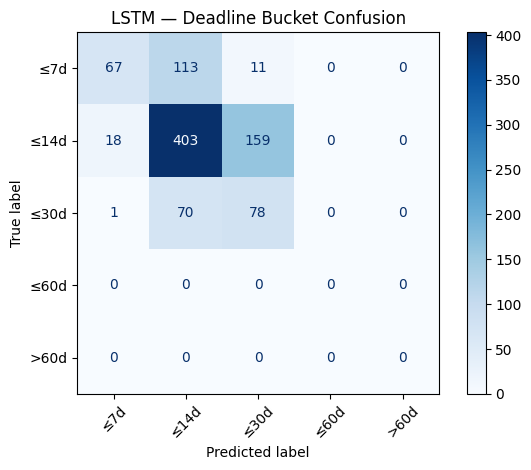

In [22]:

bins = [0,7,14,30,60,9999]
labels = ["≤7d","≤14d","≤30d","≤60d",">60d"]
y_true_cat = pd.cut(y_test, bins=bins, labels=labels)
y_pred_cat = pd.cut(y_hat_test, bins=bins, labels=labels)
cm = confusion_matrix(y_true_cat, y_pred_cat, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("LSTM — Deadline Bucket Confusion")
plt.tight_layout()
plt.show()


In [23]:

from scipy.sparse import hstack

tfidf = TfidfVectorizer(max_features=20000, ngram_range=(1,2), lowercase=True)
ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=True)
scaler = StandardScaler(with_mean=False)

X_sum_train = tfidf.fit_transform(X_train["summary"].values)
X_sum_val   = tfidf.transform(X_val["summary"].values)
X_sum_test  = tfidf.transform(X_test["summary"].values)

X_cat_train = ohe.fit_transform(X_train[["issuetype","project"]])
X_cat_val   = ohe.transform(X_val[["issuetype","project"]])
X_cat_test  = ohe.transform(X_test[["issuetype","project"]])

X_num_train = scaler.fit_transform(X_train[["priorityid","storypoint"]].astype(float))
X_num_val   = scaler.transform(X_val[["priorityid","storypoint"]].astype(float))
X_num_test  = scaler.transform(X_test[["priorityid","storypoint"]].astype(float))

X_train_dnn = hstack([X_sum_train, X_cat_train, X_num_train])
X_val_dnn   = hstack([X_sum_val,   X_cat_val,   X_num_val])
X_test_dnn  = hstack([X_sum_test,  X_cat_test,  X_num_test])

INPUT_DIM = X_train_dnn.shape[1]
dnn_inp = layers.Input(shape=(INPUT_DIM,), dtype=tf.float32)
h = layers.Dense(512, activation="relu")(dnn_inp)
h = layers.Dropout(0.3)(h)
h = layers.Dense(256, activation="relu")(h)
h = layers.Dropout(0.2)(h)
h = layers.Dense(128, activation="relu")(h)
dnn_out = layers.Dense(1, activation="linear")(h)

model_dnn = models.Model(dnn_inp, dnn_out, name="deadline_dnn_tfidf")
model_dnn.compile(optimizer="adam", loss="mae", metrics=["mse"])

# Convert sparse to dense for training (works for moderate sizes)
Xtr_np  = X_train_dnn.toarray().astype("float32")
Xva_np  = X_val_dnn.toarray().astype("float32")
Xte_np  = X_test_dnn.toarray().astype("float32")
ytr_np  = y_train.values.astype("float32")
yva_np  = y_val.values.astype("float32")
yte_np  = y_test.values.astype("float32")

es2 = callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor="val_loss")
hist_dnn = model_dnn.fit(
    Xtr_np, ytr_np, validation_data=(Xva_np, yva_np),
    epochs=30, batch_size=256, callbacks=[es2], verbose=1
)

y_hat_val_dnn  = model_dnn.predict(Xva_np).ravel()
y_hat_test_dnn = model_dnn.predict(Xte_np).ravel()

def eval_reg2(y_true, y_pred, name):
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"[{name}] MAE={mae:.2f} | MAPE={mape:.2%} | RMSE={rmse:.2f} | R²={r2:.3f}")
    return mae, mape, rmse, r2

eval_reg2(y_val.values, y_hat_val_dnn, "DNN VAL")
eval_reg2(y_test.values, y_hat_test_dnn, "DNN TEST")


Epoch 1/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - loss: 8.0971 - mse: 92.3918 - val_loss: 4.1498 - val_mse: 30.0336
Epoch 2/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 3.7779 - mse: 22.9585 - val_loss: 3.3357 - val_mse: 19.8888
Epoch 3/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 3.0766 - mse: 16.9331 - val_loss: 2.8723 - val_mse: 16.2819
Epoch 4/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 2.6496 - mse: 13.8381 - val_loss: 2.7181 - val_mse: 15.4036
Epoch 5/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 2.2941 - mse: 11.0322 - val_loss: 2.6689 - val_mse: 15.1117
Epoch 6/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 2.0127 - mse: 8.9578 - val_loss: 2.6325 - val_mse: 15.5002
Epoch 7/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 1.8439 - mse: 7.7013 - val_loss: 2.6490 - val_mse: 15.4820
Epoch 8/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 1.7311 - mse: 6.8649 - val_loss: 2.6323 - val_mse: 16.1829
Epoch 9/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step

(2.788526652170264,
 0.27687100639694456,
 4.2997879412403925,
 0.2714119250753788)

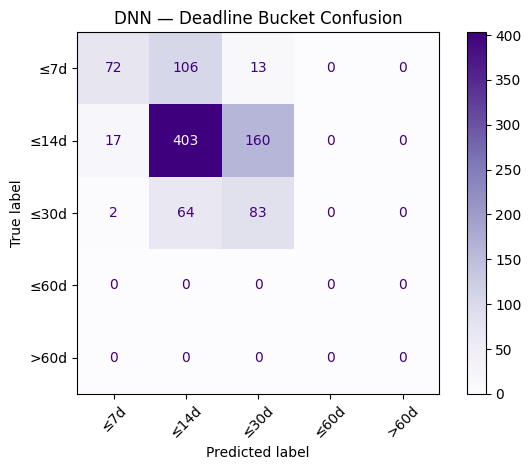

In [24]:

y_true_cat = pd.cut(y_test.values, bins=bins, labels=labels)
y_pred_cat = pd.cut(y_hat_test_dnn, bins=bins, labels=labels)
cm = confusion_matrix(y_true_cat, y_pred_cat, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap="Purples", xticks_rotation=45)
plt.title("DNN — Deadline Bucket Confusion")
plt.tight_layout()
plt.show()


In [68]:

def predict_deadline_lstm(item: dict):
    row = {
        "issuetype": str(item.get("issuetype","Task")),
        "priorityid": float(item.get("priorityid",3)),
        "storypoint": float(item.get("storyPoint", item.get("storypoint", 5))),
        "project": str(item.get("project","TKTI")),
        "summary": str(item.get("summary","")),
    }
    inp = {
        "summary": np.array([row["summary"]], dtype=object),
        "issuetype": np.array([row["issuetype"]], dtype=object),
        "project": np.array([row["project"]], dtype=object),
        "priorityid": np.array([[row["priorityid"]]], dtype="float32"),
        "storypoint": np.array([[row["storypoint"]]], dtype="float32"),
    }
    days = float(model_lstm.predict(inp, verbose=0).ravel()[0])
    return int(max(1, round(days)))

def predict_deadline_dnn(item: dict):
    sum_vec = tfidf.transform([item.get("summary","")])
    cat_vec = ohe.transform([[item.get("issuetype","Task"), item.get("project","TKTI")]])
    num_vec = scaler.transform([[float(item.get("priorityid",3)), float(item.get("storyPoint", item.get("storypoint",5)))]])

    from scipy.sparse import hstack
    Xs = hstack([sum_vec, cat_vec, num_vec]).toarray().astype("float32")
    days = float(model_dnn.predict(Xs, verbose=0).ravel()[0])
    return int(max(1, round(days)))

sample = {"issuetype":"Task","priorityid":3,"storyPoint":5,"project":"TKTI","summary":"n8n test created"}
print("LSTM days:", predict_deadline_lstm(sample))
print("DNN days :", predict_deadline_dnn(sample))


LSTM days: 12
DNN days : 13
